In [1]:
from manim import *
from manim_custom import *

quality = "ql"
config['background_color'] = WHITE

In [2]:
import openseespy.opensees as ops
import numpy as np


def analyze_truss_with_opensees(nodes, connectivity_matrix, supports, loads, A_list, E_list):
    """
    Parameters:
        nodes: np.array of shape (n_nodes, 3)
        connectivity_matrix: np.array of shape (n_elements, 2)
        supports: dict {node_index: (fix_x, fix_y)}
        loads: dict {node_index: [Fx, Fy]}
        A_list: list of cross-sectional areas (length = n_elements)
        E_list: list of Young's moduli (length = n_elements)

    Returns:
        displacements: dict {node_index: [ux, uy]}
    """

    ops.wipe()
    ops.model('basic', '-ndm', 2, '-ndf', 2)

    # Create nodes
    for i, (x, y, _) in enumerate(nodes):
        ops.node(i, x, y)

    # Supports
    for node_id, (fix_x, fix_y) in supports.items():
        ops.fix(node_id, int(fix_x), int(fix_y))

    # Define elements and materials
    for i, (ni, nj) in enumerate(connectivity_matrix):
        E = E_list[i]
        A = A_list[i]
        ops.uniaxialMaterial("Elastic", i, E)
        ops.element("truss", i, int(ni), int(nj), A, i)

    # Apply loads
    ops.timeSeries("Linear", 1)
    ops.pattern("Plain", 1, 1)
    for node_id, (Fx, Fy) in loads.items():
        ops.load(node_id, Fx, Fy)

    # Static analysis
    ops.system("SparseGeneral")
    ops.numberer("RCM")
    ops.constraints("Plain")
    ops.integrator("LoadControl", 1.0)
    ops.algorithm("Linear")
    ops.analysis("Static")
    ops.analyze(1)

    # Get displacements
    displacements = np.array([
        [ops.nodeDisp(i, 1), ops.nodeDisp(i, 2)]
        for i in range(len(nodes))
    ])

    forces = np.array([ops.eleResponse(i, 'axialForce')[0] for i in range(len(connectivity_matrix))])

    return displacements, forces

ModuleNotFoundError: No module named 'openseespy'

In [ ]:
%%manim -r 2000,500 --format png -t -qk -o 03_real_truss_example_schematics -v WARNING ExampleTruss
nodes = np.array([(0, 0, 0), (4, 0, 0), (8, 0, 0), (12, 0, 0),
                  (16, 0, 0), (20, 0, 0), (24, 0, 0), (28, 0, 0),
                  (4, 6, 0), (8, 6, 0), (12, 6, 0),
                  (16, 6, 0), (20, 6, 0), (24, 6, 0)], dtype=float)

supports = {0: (True, True), 7: (False, True)}
connectivity_matrix = np.array([(0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6), (6, 7), (7, 13),
                                (8, 9), (9, 10), (10, 11), (11, 12), (12, 13), (8, 0),
                                (1, 8), (2, 9), (3, 10), (4, 11), (5, 12), (6, 13),
                                (2, 8), (3, 9), (4, 10), (3, 11), (4, 12), (5, 13)])

A = [.1] * len(connectivity_matrix)
E = [210e9] * len(connectivity_matrix)

loads = {k: (0., -1000.e3) for k in range(1, 7)}

u, N = analyze_truss_with_opensees(nodes, connectivity_matrix, supports, loads, A, E)


class ExampleTruss(MovingCameraScene):
    def __init__(self, **kargs):
        super().__init__(**kargs)
        self.camera.resize_frame_shape(0)
        self.camera.frame.scale(2.1)
        self.camera.frame.move_to(ORIGIN)

    def construct(self):
        g = Truss(nodes=nodes,
                  connectivity_matrix=connectivity_matrix,
                  supports=supports,
                  display_loads=False,
                  loads=loads,
                  displacements=u,
                  member_style={'stroke_width': 5},
                  node_style={'radius': .15},
                  support_style={'height': .75},
                  deformed_style={'dash_length': .25})
        g.move_to(ORIGIN)
        g.update()
        self.add(g)

In [3]:
%%manim -r 800,800 --format png -t -qk -o 03_pinned_support -v WARNING PinnedSupportMove

class PinnedSupportMove(MovingCameraScene):
    def __init__(self, **kargs):
        super().__init__(**kargs)
        self.camera.resize_frame_shape(0)
        self.camera.frame.scale(.5)

    def construct(self):
        g = Truss(nodes=nodes,
                  connectivity_matrix=connectivity_matrix,
                  supports=supports,
                  display_loads=False,
                  loads=loads,
                  displacements=u,
                  member_style={'stroke_width': 5},
                  node_style={'radius': .15},
                  deformed_node_style={'radius': .1},
                  support_style={'height': 2},
                  deformed_style={'dash_length': .25, 'stroke_width': 4})
        g.move_to(ORIGIN)
        g.overlap_deformation(scale=300)
        g.update()
        self.camera.frame.move_to(VGroup([g.nodes[i] for i in (0, 1, 8)]).get_center())
        self.camera.frame.shift(DOWN * 2).shift(1 * LEFT)
        self.add(g)

Manim Community v0.19.0

[07/05/25 17:01:16] WARNING  Output format changed to '.mov' to support transparency                  ]8;id=782247;file:///Users/aflamant/miniconda3/envs/manim-env/lib/python3.12/site-packages/manim/_config/utils.py\utils.py]8;;\:]8;id=993741;file:///Users/aflamant/miniconda3/envs/manim-env/lib/python3.12/site-packages/manim/_config/utils.py#1435\1435]8;;\

NameError: name 'nodes' is not defined

In [4]:
%%manim -r 800,800 --format png -t -qk -o 03_rolling_support -v WARNING RollingSupportMove

class RollingSupportMove(MovingCameraScene):
    def __init__(self, **kargs):
        super().__init__(**kargs)
        self.camera.resize_frame_shape(0)
        self.camera.frame.scale(.5)

    def construct(self):
        g = Truss(nodes=nodes,
                  connectivity_matrix=connectivity_matrix,
                  supports=supports,
                  display_loads=False,
                  loads=loads,
                  displacements=u,
                  member_style={'stroke_width': 5},
                  node_style={'radius': .15},
                  deformed_node_style={'radius': .1},
                  support_style={'height': 2},
                  deformed_style={'dash_length': .25})
        g.move_to(ORIGIN)
        g.overlap_deformation(scale=300)
        g.update()
        self.camera.frame.move_to(VGroup([g.nodes[i] for i in (7, 13, 6)]).get_center())
        self.camera.frame.shift(DOWN * 2).shift(1 * RIGHT)
        self.add(g)

Manim Community v0.19.0

                    WARNING  Output format changed to '.mov' to support transparency                  ]8;id=248188;file:///Users/aflamant/miniconda3/envs/manim-env/lib/python3.12/site-packages/manim/_config/utils.py\utils.py]8;;\:]8;id=230036;file:///Users/aflamant/miniconda3/envs/manim-env/lib/python3.12/site-packages/manim/_config/utils.py#1435\1435]8;;\

NameError: name 'nodes' is not defined

Manim Community v0.19.0

[06/22/25 15:12:18] WARNING  Output format changed to '.mov' to support transparency                  ]8;id=487858;file:///Users/aflamant/miniconda3/envs/x86manim/lib/python3.12/site-packages/manim/_config/utils.py\utils.py]8;;\:]8;id=579120;file:///Users/aflamant/miniconda3/envs/x86manim/lib/python3.12/site-packages/manim/_config/utils.py#1435\1435]8;;\

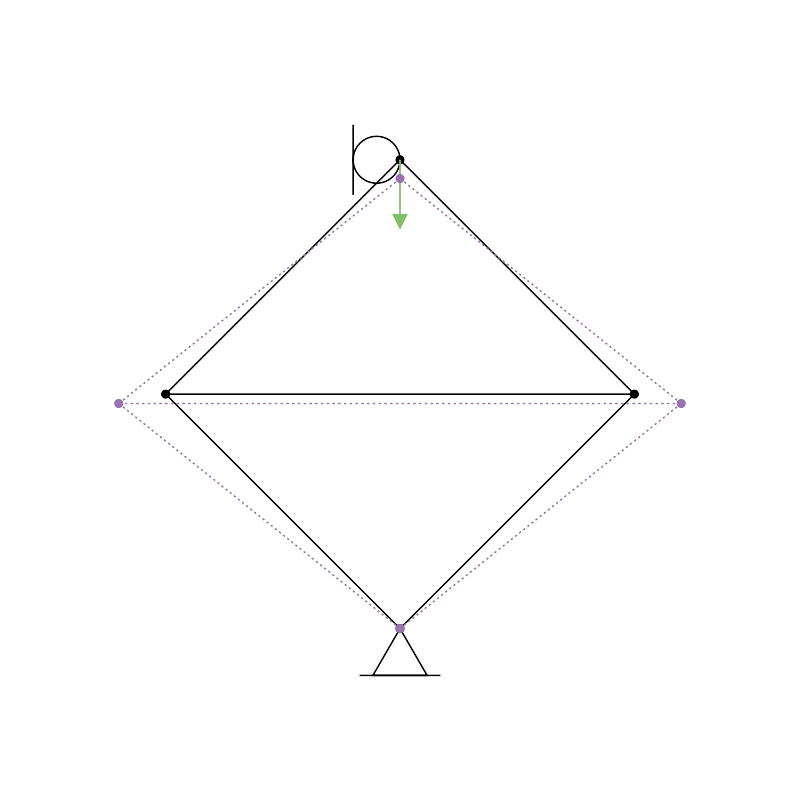

In [97]:
%%manim -r 800,800 --format png -t -qk -o 03_triangulated -v WARNING TriangulatedTruss

nodes = np.array([(0, 0, 0), (5, 5, 0), (0, 10, 0), (-5, 5, 0)], dtype=float)
supports = {0: (True, True), 2: (True, False)}
connectivity_matrix = np.array([(0, 1), (1, 2), (2, 3), (3, 0), (1, 3)])
loads = {2: [0., -1000e3]}

u = np.array([
    [0, 0], [.1, -.02], [0, -.04], [-.1, -.02],
])


class TriangulatedTruss(MovingCameraScene):
    def __init__(self, **kargs):
        super().__init__(**kargs)
        self.camera.frame.scale(1.2)

    def construct(self):
        g = Truss(nodes=nodes,
                  connectivity_matrix=connectivity_matrix,
                  supports=supports,
                  loads=loads,
                  displacements=u,
                  deformed_node_style={'radius': .1},
                  support_style={'height': 1},
                  node_label_offsets=[.4 * UP, .4 * (UP + RIGHT), .4 * UP, .4 * UP],
                  member_label_offsets=[.3 * UP, .3 * UP, .3 * UR, .3 * UL, .4 * RIGHT],
                  )
        g.move_to(ORIGIN)
        g.overlap_deformation(scale=10)
        g.update()

        self.add(g)

Manim Community v0.19.0

[06/22/25 15:11:44] WARNING  Output format changed to '.mov' to support transparency                  ]8;id=554167;file:///Users/aflamant/miniconda3/envs/x86manim/lib/python3.12/site-packages/manim/_config/utils.py\utils.py]8;;\:]8;id=780032;file:///Users/aflamant/miniconda3/envs/x86manim/lib/python3.12/site-packages/manim/_config/utils.py#1435\1435]8;;\

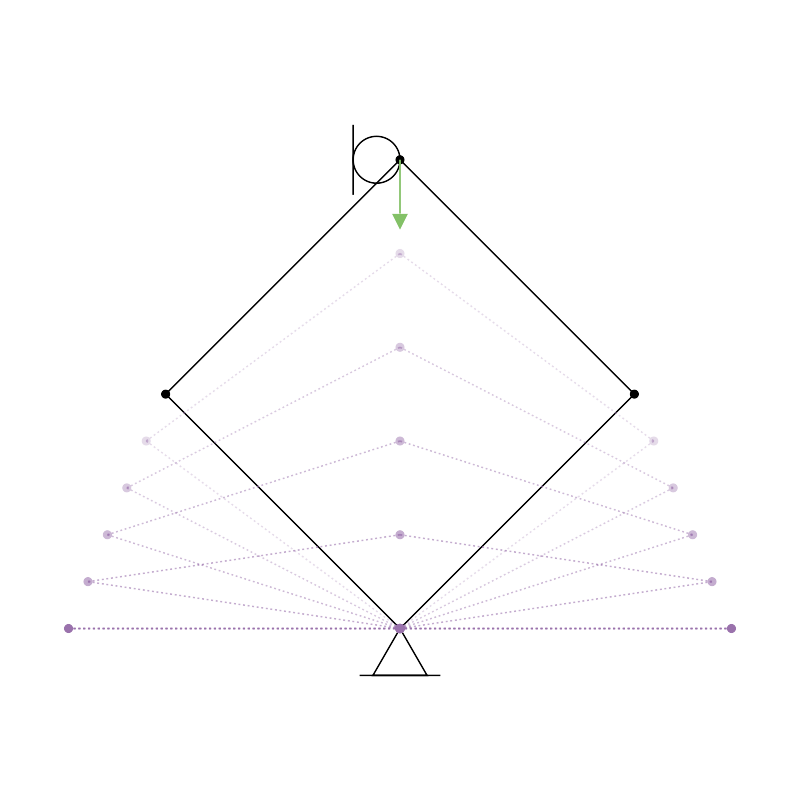

In [96]:
%%manim -r 800,800 --format png -t -qk -o 03_untriangulated -v WARNING UntriangulatedTruss

nodes = np.array([(0, 0, 0), (5, 5, 0), (0, 10, 0), (-5, 5, 0)], dtype=float)
supports = {0: (True, True), 2: (True, False)}
connectivity_matrix = np.array([(0, 1), (1, 2), (2, 3), (3, 0)])
loads = {2: [0., -1000e3]}

u = np.array([
    [0, 0], [(2 ** .5 - 1) * 5, -5], [0, -10], [-(2 ** .5 - 1) * 5, -5],
])


class UntriangulatedTruss(MovingCameraScene):
    def __init__(self, **kargs):
        super().__init__(**kargs)
        self.camera.frame.scale(1.2)

    def construct(self):
        g = Truss(nodes=nodes,
                  connectivity_matrix=connectivity_matrix,
                  supports=supports,
                  loads=loads,
                  displacements=u,
                  deformed_node_style={'radius': .1},
                  support_style={'height': 1},
                  node_label_offsets=[.4 * UP, .4 * (UP + RIGHT), .4 * UP, .4 * UP],
                  member_label_offsets=[.3 * UP, .3 * UP, .3 * UR, .3 * UL, .4 * RIGHT],
                  )
        g.move_to(ORIGIN)

        n = 5
        for i in range(0, n):
            g.overlap_deformation(scale=i * 1 / n)
            g.update()
            vmo_n = g.displaced_nodes
            vmo_m = g.displaced_members
            vmo_n.set_opacity((i / 10) ** .3)
            vmo_m.set_opacity((i / 10) ** .3)

        g.overlap_deformation(scale=1.)
        self.add(g)

Manim Community v0.19.0

[06/21/25 21:11:15] WARNING  Output format changed to '.mov' to support transparency                  ]8;id=560643;file:///Users/aflamant/miniconda3/envs/x86manim/lib/python3.12/site-packages/manim/_config/utils.py\utils.py]8;;\:]8;id=155141;file:///Users/aflamant/miniconda3/envs/x86manim/lib/python3.12/site-packages/manim/_config/utils.py#1435\1435]8;;\

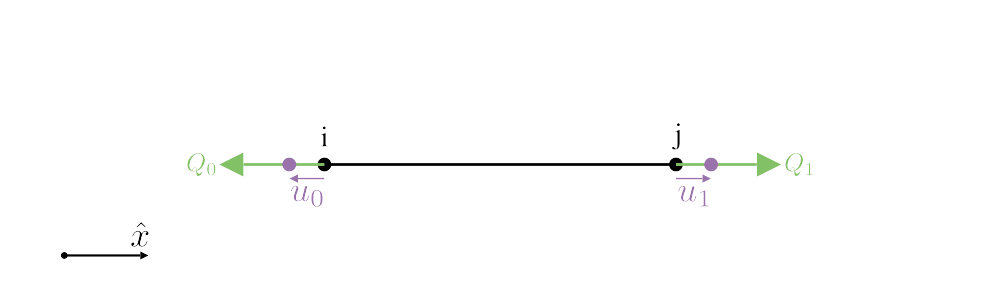

In [8]:
%%manim -r 1000,300 --format png -t -qk -o 03_local_element -v WARNING LocalElement

class LocalElement(MovingCameraScene):
    def construct(self):
        g = Truss(nodes=np.array([[0, 0, 0], [5, 0, 0]], dtype=float),
                  connectivity_matrix=[[0, 1]],
                  supports={},
                  displacements=np.array([[-1, 0], [1, 0]]),
                  loads={0: [-1., 0.], 1: [1., 0.]},
                  node_labels=['i', 'j'],
                  node_label_offsets=[.4 * UP, .4 * UP],
                  node_label_style={'weight': NORMAL},
                  display_node_labels=True,
                  display_load_labels=True,
                  load_labels=['$Q_0$', '$Q_1$'],
                  load_label_style={'prefix': '', 'suffix': ''},
                  load_label_offsets=[LEFT, RIGHT],
                  deformed_style={'stroke_width': 0},
                  deformed_node_style={'radius': .1})

        g.move_to(ORIGIN)
        g.overlap_deformation(scale=.5)
        g.update()

        arrow1 = Arrow(g.nodes[0].get_center(), g.displaced_nodes[0].get_center(), buff=0, color=PURPLE).shift(
            .2 * DOWN)
        arrow2 = Arrow(g.nodes[1].get_center(), g.displaced_nodes[1].get_center(), buff=0, color=PURPLE).shift(
            .2 * DOWN)

        text1 = Tex("$u_0$", color=PURPLE).move_to(arrow1.get_center()).shift(.25 * DOWN)
        text2 = Tex("$u_1$", color=PURPLE).move_to(arrow2.get_center()).shift(.25 * DOWN)

        axis = (Arrow([0, 0, 0], [1.2, 0, 0], color=BLACK, stroke_width=10, buff=0,
                      max_tip_length_to_length_ratio=.1, max_stroke_width_to_length_ratio=3)
                .shift(1.5 * DOWN))

        axis.align_to(g.loads[0].get_end(), RIGHT).shift(LEFT)

        axis_base = Dot(axis.get_start(), color=BLACK, radius=.05)

        text3 = (Tex(r"$\hat{x}$", color=BLACK).move_to(arrow1.get_center()).shift(.2 * DOWN)
                 .move_to(axis.get_center())
                 .align_to(axis, RIGHT)
                 .shift(.3 * UP))

        self.add(g, arrow1, arrow2, text1, text2, axis, axis_base, text3)

Manim Community v0.19.0

                    WARNING  Output format changed to '.mov' to support transparency                  ]8;id=677682;file:///Users/aflamant/miniconda3/envs/x86manim/lib/python3.12/site-packages/manim/_config/utils.py\utils.py]8;;\:]8;id=224428;file:///Users/aflamant/miniconda3/envs/x86manim/lib/python3.12/site-packages/manim/_config/utils.py#1435\1435]8;;\

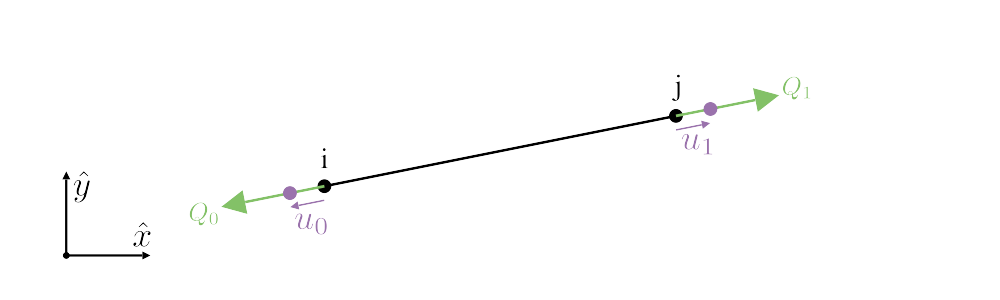

In [9]:
%%manim -r 1000,300 --format png -t -qk -o 03_global_element -v WARNING GlobalElement

class GlobalElement(MovingCameraScene):
    def construct(self):
        loads = {0: np.array([-1., -.2]), 1: np.array([1., .2])}
        for k, load in loads.items():
            loads[k] = load / np.linalg.norm(load)

        u = np.array([[-1., -.2], [1., .2]], dtype=float)
        u /= np.linalg.norm(u, axis=1)

        g = Truss(nodes=np.array([[0, 0, 0], [5, 1, 0]], dtype=float),
                  connectivity_matrix=[[0, 1]],
                  supports={},
                  displacements=u,
                  loads=loads,
                  node_labels=['i', 'j'],
                  node_label_offsets=[.4 * UP, .4 * UP],
                  node_label_style={'weight': NORMAL},
                  display_node_labels=True,
                  display_load_labels=True,
                  load_labels=['$Q_0$', '$Q_1$'],
                  load_label_style={'prefix': '', 'suffix': ''},
                  load_label_offsets=[[loads[0][0], loads[0][1], 0], [loads[1][0], loads[1][1], 0]],
                  deformed_style={'stroke_width': 0},
                  deformed_node_style={'radius': .1})

        g.move_to(ORIGIN)
        g.overlap_deformation(scale=.5)
        g.update()

        arrow1 = Arrow(g.nodes[0].get_center(), g.displaced_nodes[0].get_center(), buff=0, color=PURPLE).shift(
            .2 * DOWN)
        arrow2 = Arrow(g.nodes[1].get_center(), g.displaced_nodes[1].get_center(), buff=0, color=PURPLE).shift(
            .2 * DOWN)

        text1 = (Tex("$u_0$", color=PURPLE).move_to(arrow1.get_center())
                 .shift(.55 * arrow1.copy().rotate(.5 * PI).get_vector()))
        text2 = (Tex("$u_1$", color=PURPLE).move_to(arrow2.get_center())
                 .shift(.55 * arrow2.copy().rotate(-.5 * PI).get_vector()))

        axis1 = (Arrow([0, 0, 0], [1.2, 0, 0], color=BLACK, stroke_width=10, buff=0,
                       max_tip_length_to_length_ratio=.1, max_stroke_width_to_length_ratio=3)
                 .shift(1.5 * DOWN))
        axis1.align_to(g.loads[0].get_end(), RIGHT).shift(LEFT)

        axis2 = Arrow(axis1.get_start(), axis1.get_start() + 1.2 * UP, color=BLACK, stroke_width=10, buff=0,
                      max_tip_length_to_length_ratio=.1, max_stroke_width_to_length_ratio=3)

        axis_base = Dot(axis1.get_start(), color=BLACK, radius=.05)

        text3 = (Tex(r"$\hat{x}$", color=BLACK).move_to(arrow1.get_center())
                 .move_to(axis1.get_center())
                 .align_to(axis1, RIGHT)
                 .shift(.3 * UP))

        text4 = (Tex(r"$\hat{y}$", color=BLACK).move_to(arrow2.get_center())
                 .move_to(axis2.get_center())
                 .align_to(axis2, UP)
                 .shift(.22 * RIGHT))

        self.add(g, arrow1, arrow2, text1, text2, axis1, axis2, axis_base, text3, text4)

Manim Community v0.19.0

[06/22/25 16:57:34] WARNING  Output format changed to '.mov' to support transparency                  ]8;id=635411;file:///Users/aflamant/miniconda3/envs/x86manim/lib/python3.12/site-packages/manim/_config/utils.py\utils.py]8;;\:]8;id=817040;file:///Users/aflamant/miniconda3/envs/x86manim/lib/python3.12/site-packages/manim/_config/utils.py#1435\1435]8;;\

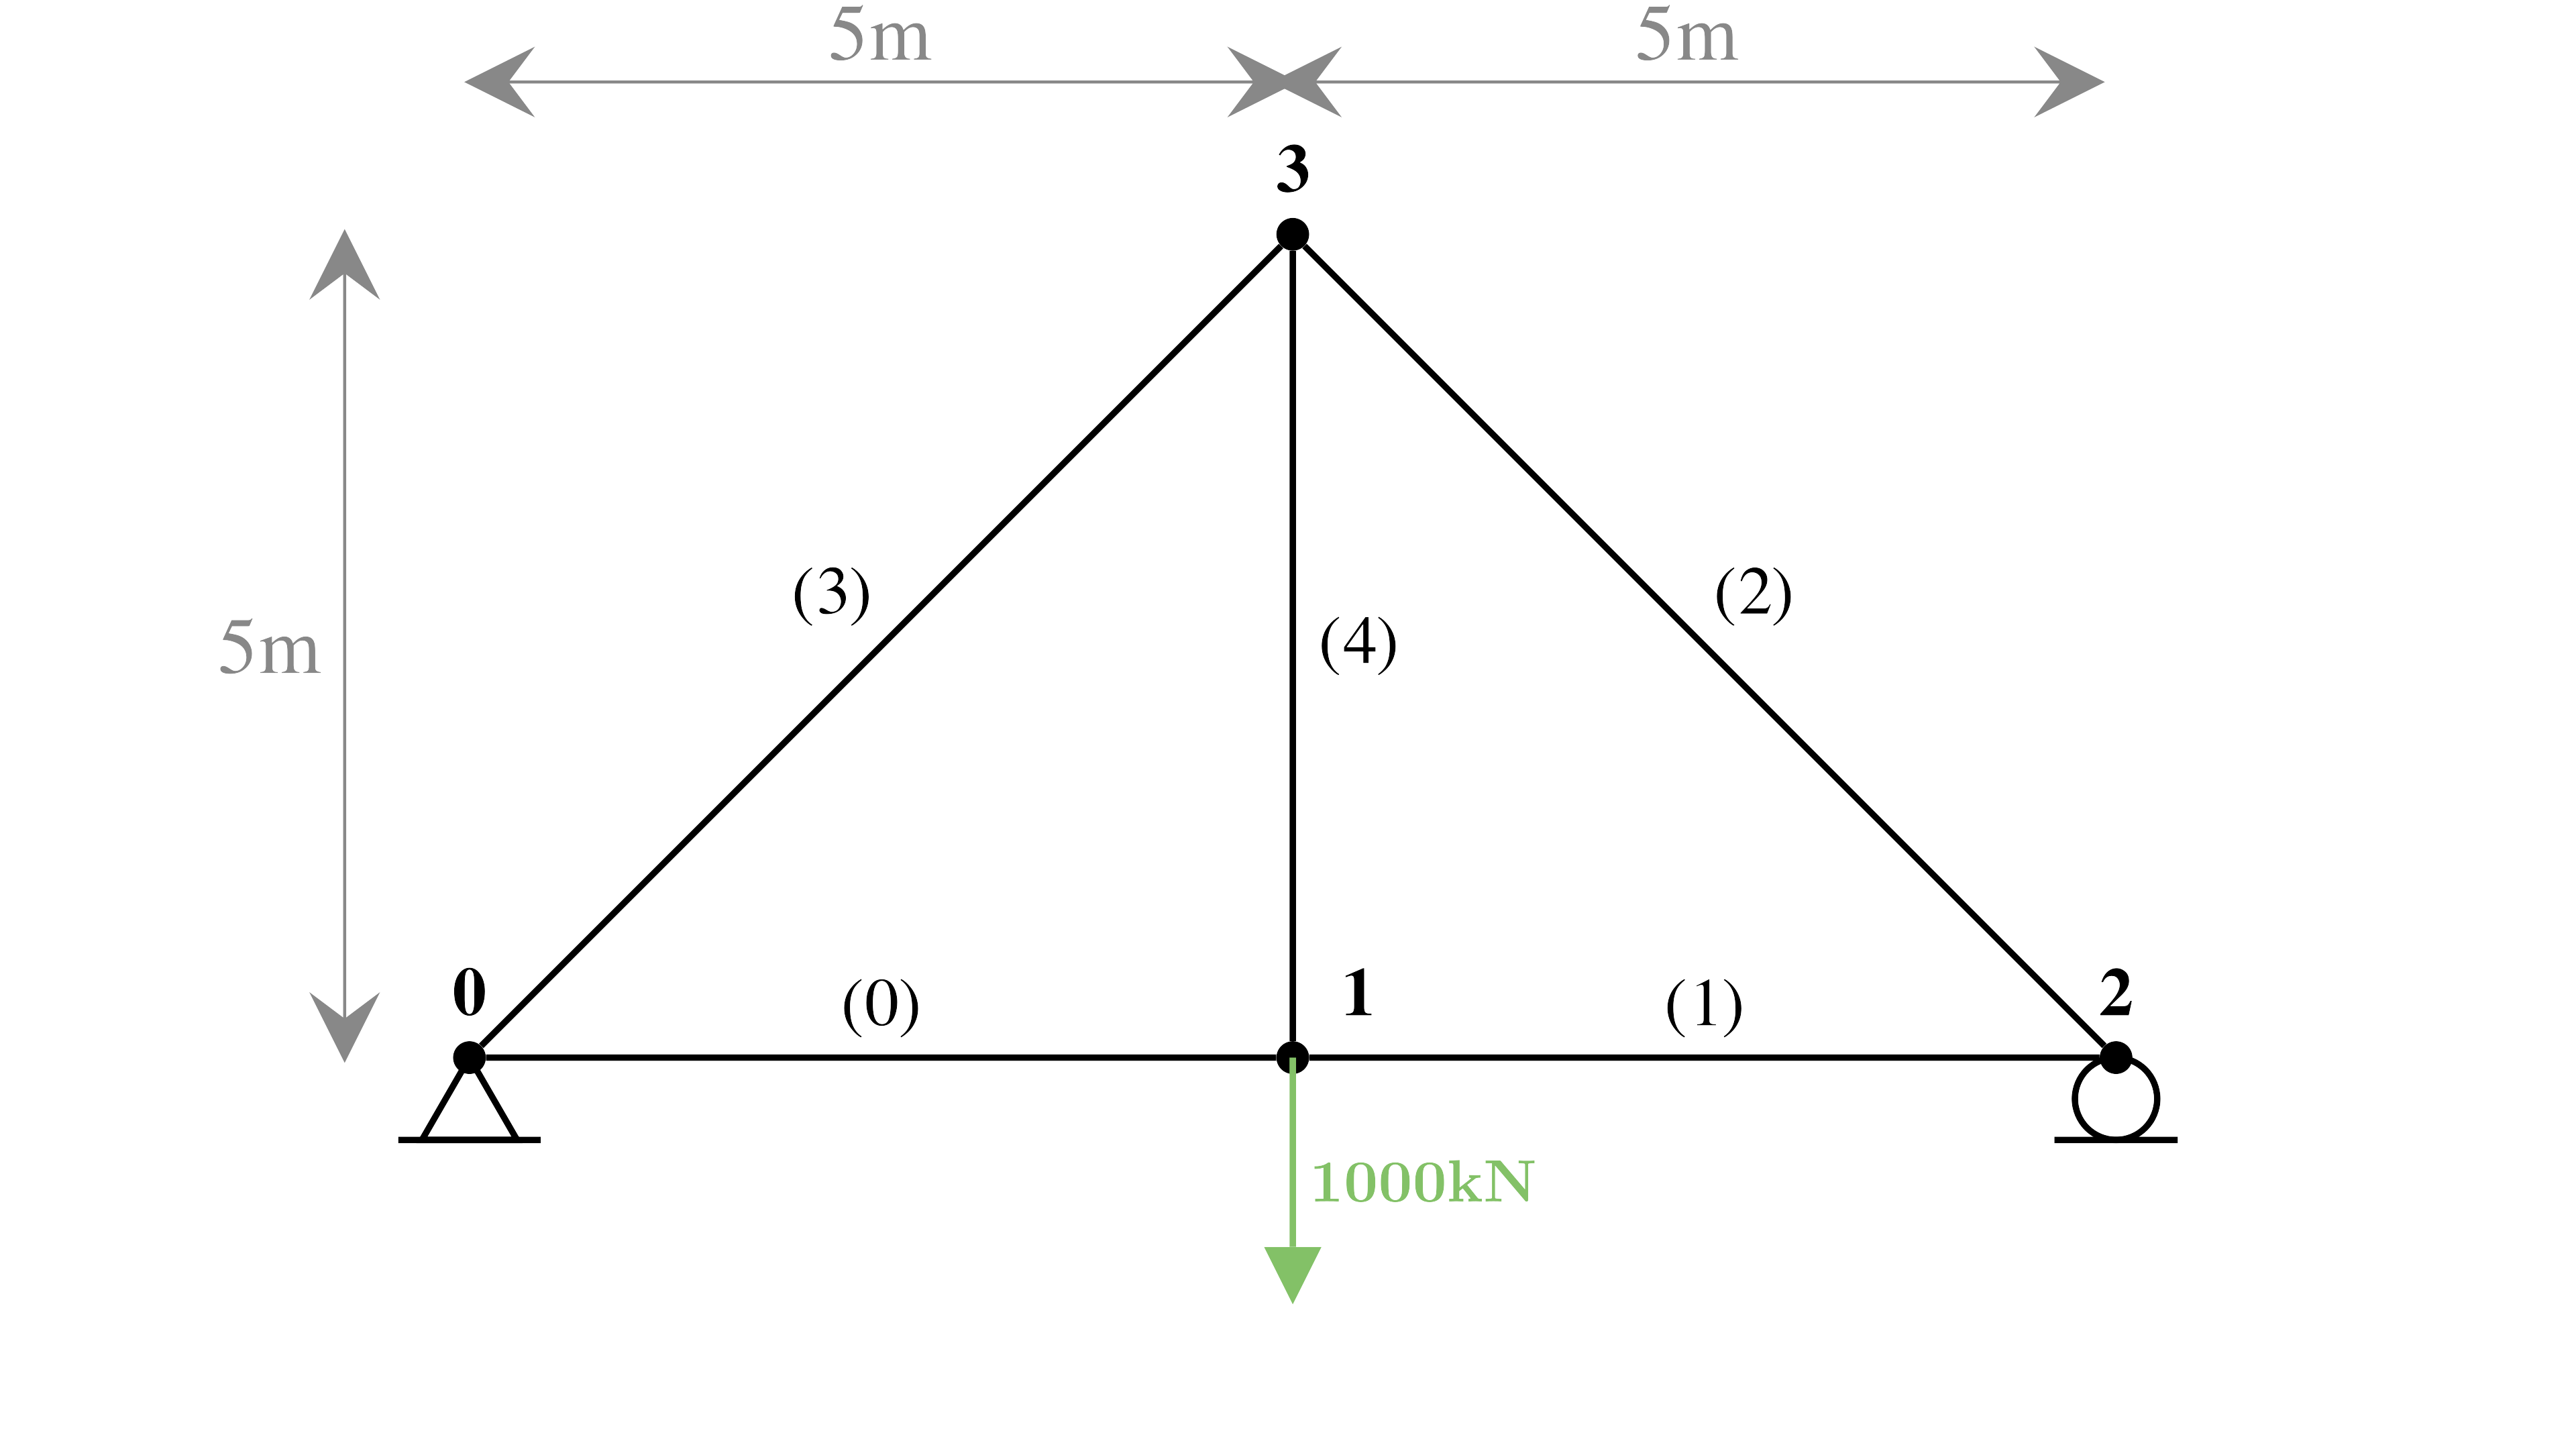

In [127]:
%%manim --format png -t -qk -o 03_example_truss -v WARNING ExampleTruss

nodes = np.array([(0, 0, 0), (5, 0, 0), (10, 0, 0), (5, 5, 0)], dtype=float)
supports = {0: (True, True), 2: (False, True)}
connectivity_matrix = np.array([(0, 1), (1, 2), (2, 3), (3, 0), (1, 3)])
loads = {1: [0., -1000e3]}

A = [.0025] * len(connectivity_matrix)
E = [210.e9] * len(connectivity_matrix)

u, N = analyze_truss_with_opensees(nodes, connectivity_matrix, supports, loads, A, E)


class ExampleTruss(MovingCameraScene):
    def __init__(self, **kargs):
        super().__init__(**kargs)
        self.camera.frame.scale(1.1)
        self.camera.frame.move_to(ORIGIN)

    def construct(self):
        g = Truss(nodes=nodes,
                  connectivity_matrix=connectivity_matrix,
                  supports=supports,
                  loads=loads,
                  displacements=u,
                  support_style={'height': .5},
                  node_label_offsets=[.4 * UP, .4 * (UP + RIGHT), .4 * UP, .4 * UP],
                  member_label_offsets=[.3 * UP, .3 * UP, .3 * UR, .3 * UL, .4 * RIGHT],
                  load_labels=['1000kN'],
                  load_label_offsets=[.8 * RIGHT],
                  load_label_style={'prefix': '\\textbf{', 'suffix': '}'},
                  display_node_labels=True,
                  display_load_labels=True,
                  display_member_labels=True)

        g.move_to(ORIGIN)
        arrow1 = (DoubleArrow(g.nodes[0].get_center(), g.nodes[1].get_center(), buff=0, color=GRAY,
                              stroke_width=2, tip_shape_start=StealthTip, tip_shape_end=StealthTip)
                  .align_to(g.nodes[3], UP)
                  .shift(UP))
        arrow2 = (arrow1.copy()
                  .align_to(g.nodes[3], LEFT))
        arrow3 = (DoubleArrow(g.nodes[1].get_center(), g.nodes[3].get_center(), buff=0, color=GRAY,
                              stroke_width=2, tip_shape_start=StealthTip, tip_shape_end=StealthTip)
                  .align_to(g.supports[0], LEFT)
                  .shift(.5 * LEFT))

        text1 = (Text("5m", color=GREY, font_size=35)
                 .move_to(arrow1.get_center())
                 .shift(.3 * UP))
        text2 = (text1.copy()
                 .move_to(arrow2.get_center())
                 .shift(.3 * UP))
        text3 = (text1.copy()
                 .move_to(arrow3.get_center())
                 .shift(.45 * LEFT))

        self.add(g, arrow1, arrow2, arrow3, text1, text2, text3)

Manim Community v0.19.0

[06/22/25 17:13:01] WARNING  Output format changed to '.mov' to support transparency                  ]8;id=71637;file:///Users/aflamant/miniconda3/envs/x86manim/lib/python3.12/site-packages/manim/_config/utils.py\utils.py]8;;\:]8;id=487591;file:///Users/aflamant/miniconda3/envs/x86manim/lib/python3.12/site-packages/manim/_config/utils.py#1435\1435]8;;\

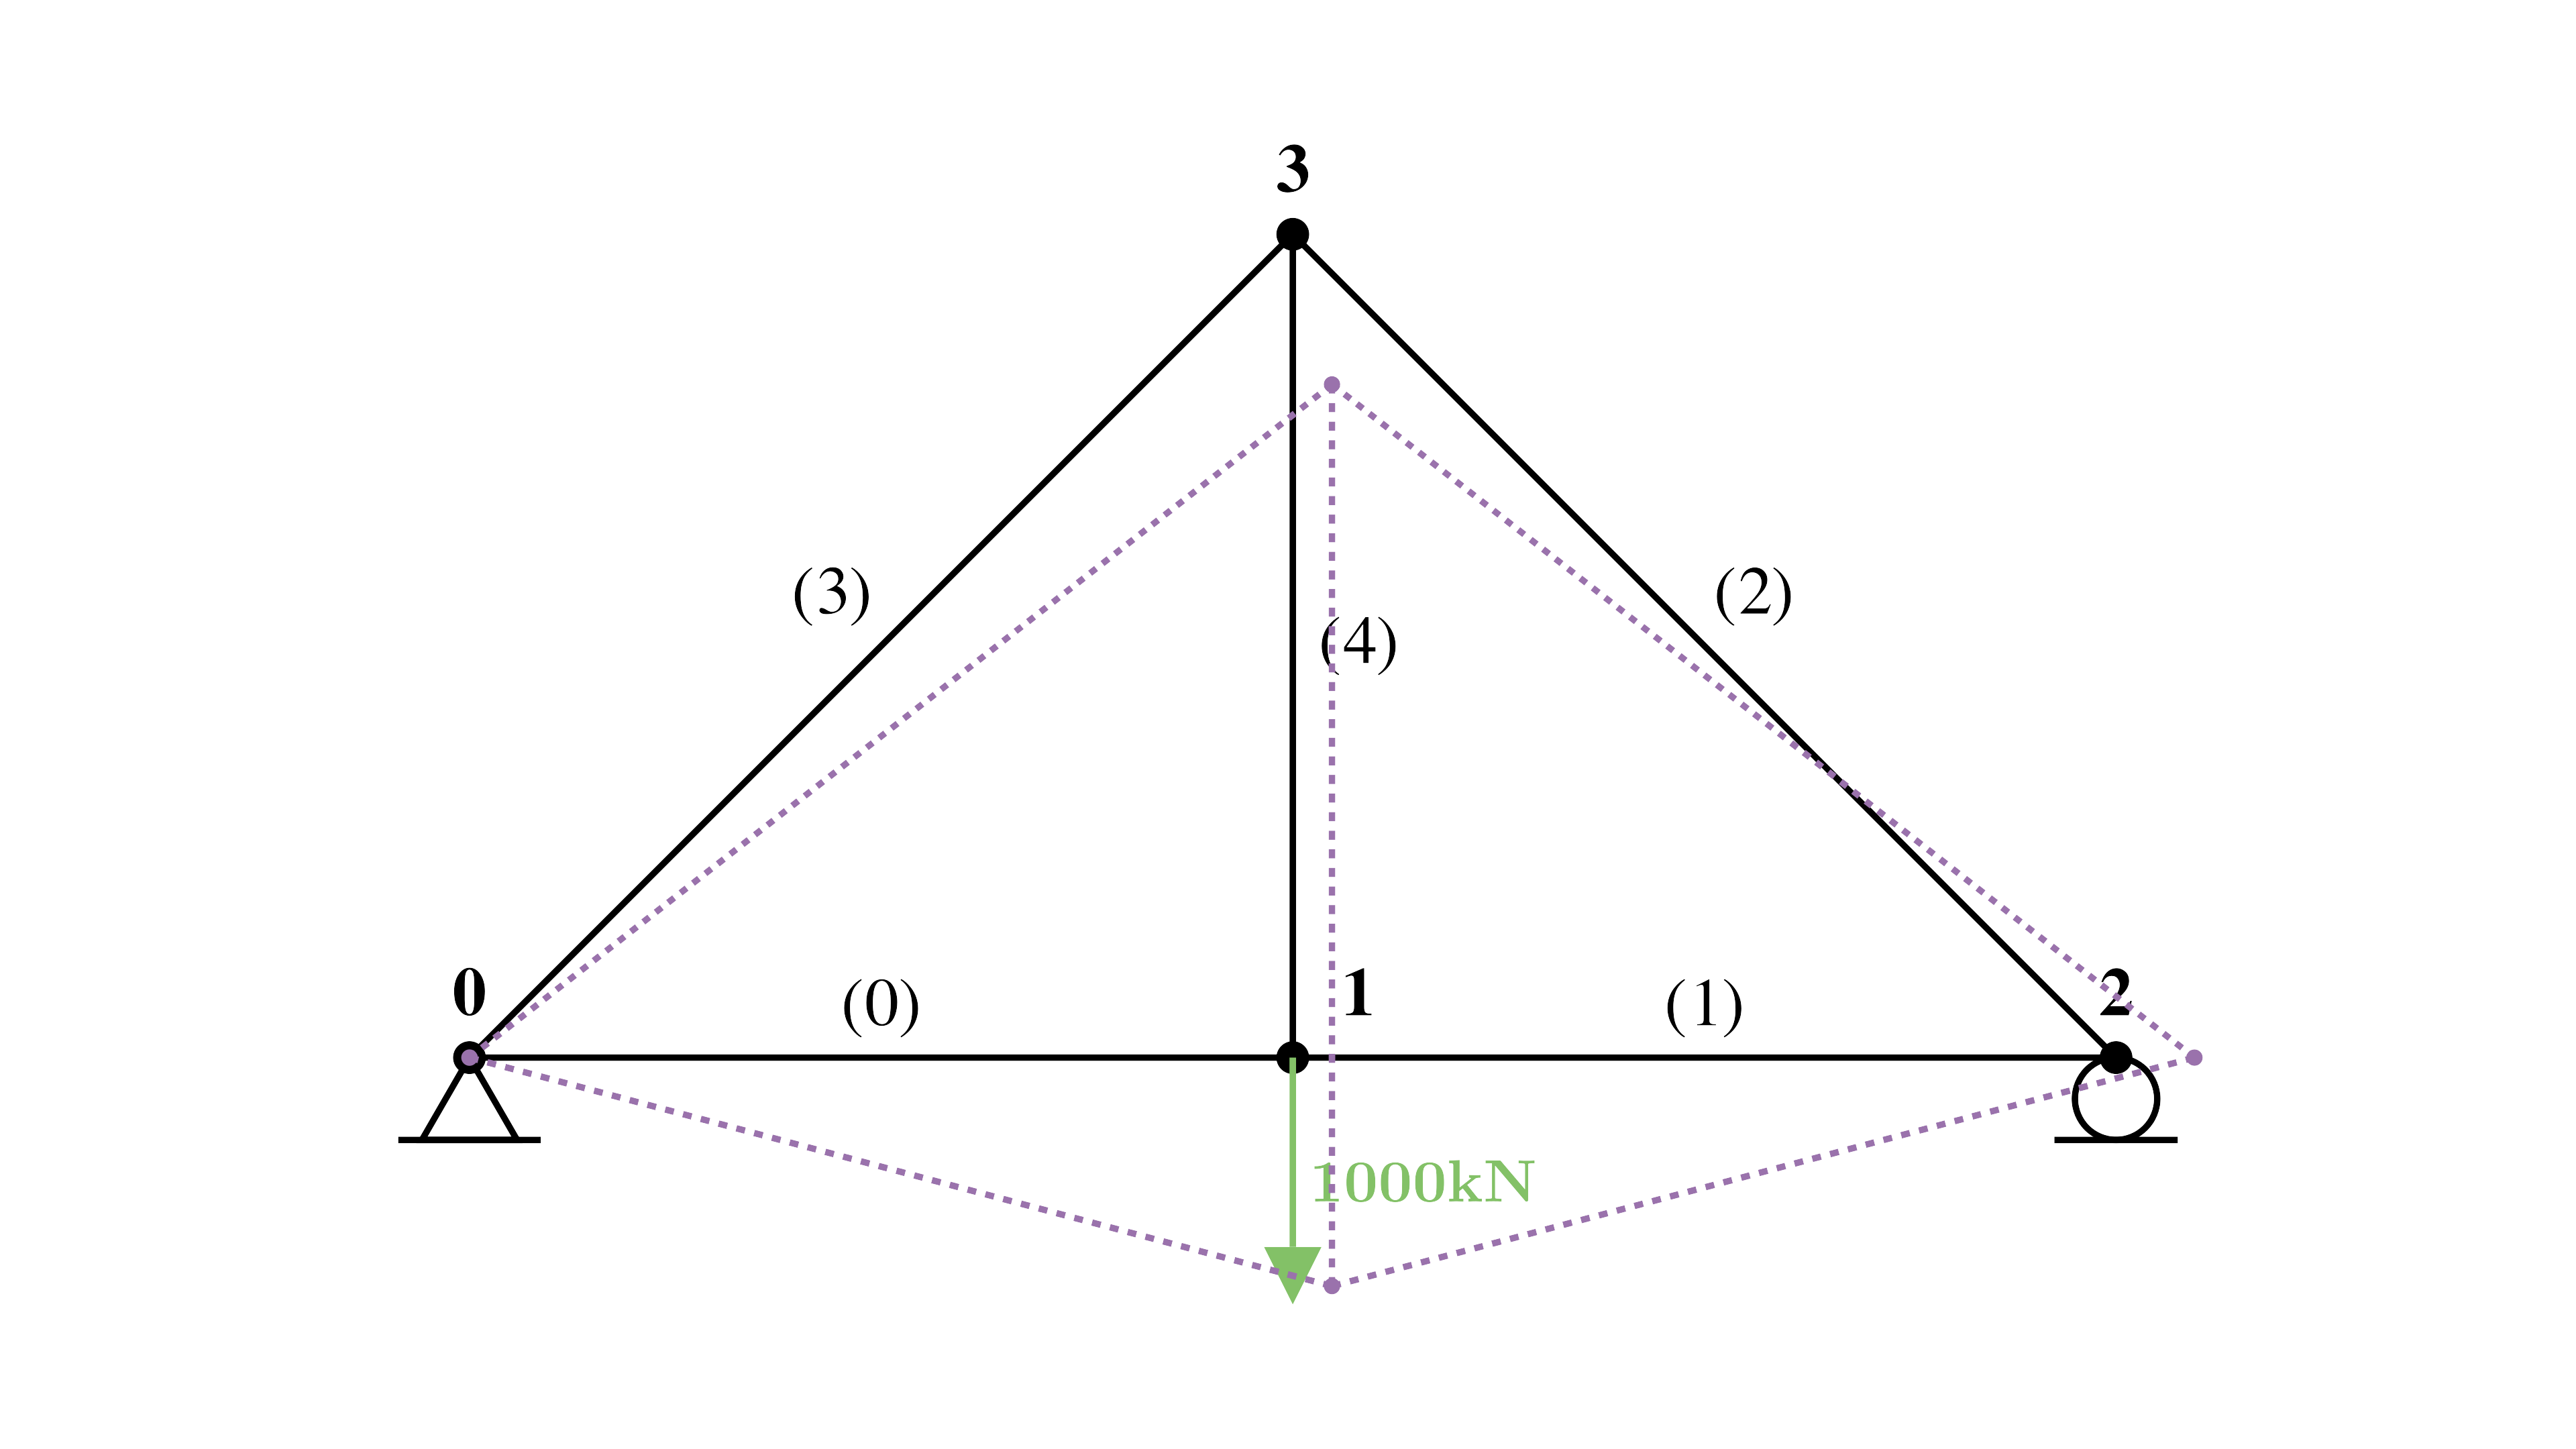

In [132]:
%%manim --format png -t -qk -o 03_example_truss_displacements -v WARNING ExampleTrussDisplacements

nodes = np.array([(0, 0, 0), (5, 0, 0), (10, 0, 0), (5, 5, 0)], dtype=float)
supports = {0: (True, True), 2: (False, True)}
connectivity_matrix = np.array([(0, 1), (1, 2), (2, 3), (3, 0), (1, 3)])
loads = {1: [0., -1000e3]}

A = [.0025] * len(connectivity_matrix)
E = [210.e9] * len(connectivity_matrix)

u, N = analyze_truss_with_opensees(nodes, connectivity_matrix, supports, loads, A, E)


class ExampleTrussDisplacements(MovingCameraScene):
    def __init__(self, **kargs):
        super().__init__(**kargs)
        self.camera.frame.scale(1.1)
        self.camera.frame.move_to(ORIGIN)

    def construct(self):
        g = Truss(nodes=nodes,
                  connectivity_matrix=connectivity_matrix,
                  supports=supports,
                  loads=loads,
                  displacements=u,
                  support_style={'height': .5},
                  node_label_offsets=[.4 * UP, .4 * (UP + RIGHT), .4 * UP, .4 * UP],
                  member_label_offsets=[.3 * UP, .3 * UP, .3 * UR, .3 * UL, .4 * RIGHT],
                  load_labels=['1000kN'],
                  load_label_offsets=[.8 * RIGHT],
                  load_label_style={'prefix': '\\textbf{', 'suffix': '}'},
                  display_node_labels=True,
                  display_load_labels=True,
                  display_member_labels=True)

        g.move_to(ORIGIN)
        g.overlap_deformation(scale=50)
        g.update()

        self.add(g)

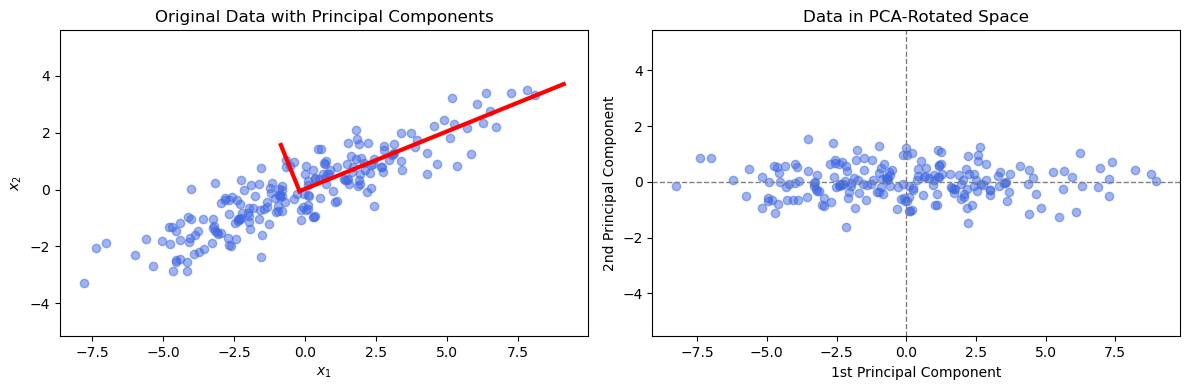

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

class PCADemo:
    def __init__(self, n_samples=200, random_seed=0):
        np.random.seed(random_seed)
        self.X = self._generate_data(n_samples)
        self.pca_2d = PCA(n_components=2)
        self.X_pca = None

    def _generate_data(self, n_samples):
        """Generate 2D correlated and dispersed Gaussian data."""
        A = np.array([[3, 1], [1, 1]])  # Increased spread
        Z = np.random.randn(n_samples, 2)
        return Z @ A.T

    def apply_pca(self):
        """Fit 2D PCA and transform the data into principal component space."""
        self.X_pca = self.pca_2d.fit_transform(self.X)

    def plot(self):
        """Plot original data and PCA-transformed (rotated) data."""
        if self.X_pca is None:
            raise RuntimeError("Call apply_pca() before plotting.")

        plt.figure(figsize=(12, 4))

        # Plot original data with principal axes
        plt.subplot(1, 2, 1)
        plt.scatter(self.X[:, 0], self.X[:, 1], alpha=0.5, color='royalblue')
        for length, vector in zip(self.pca_2d.explained_variance_, self.pca_2d.components_):
            v = vector * 3 * np.sqrt(length)
            plt.plot([self.pca_2d.mean_[0], self.pca_2d.mean_[0] + v[0]],
                     [self.pca_2d.mean_[1], self.pca_2d.mean_[1] + v[1]],
                     linewidth=3, color='red')
        plt.title("Original Data with Principal Components")
        plt.xlabel("$x_1$")
        plt.ylabel("$x_2$")
        plt.axis('equal')

        # Plot rotated data (in PCA coordinate system)
        plt.subplot(1, 2, 2)
        plt.scatter(self.X_pca[:, 0], self.X_pca[:, 1], alpha=0.5, color='royalblue')
        plt.axhline(0, color='gray', linestyle='--', linewidth=1)
        plt.axvline(0, color='gray', linestyle='--', linewidth=1)
        plt.title("Data in PCA-Rotated Space")
        plt.xlabel("1st Principal Component")
        plt.ylabel("2nd Principal Component")
        plt.axis('equal')

        plt.tight_layout()
        plt.savefig("img/03-PCA.pdf")

# Example usage
if __name__ == "__main__":
    demo = PCADemo()
    demo.apply_pca()
    demo.plot()


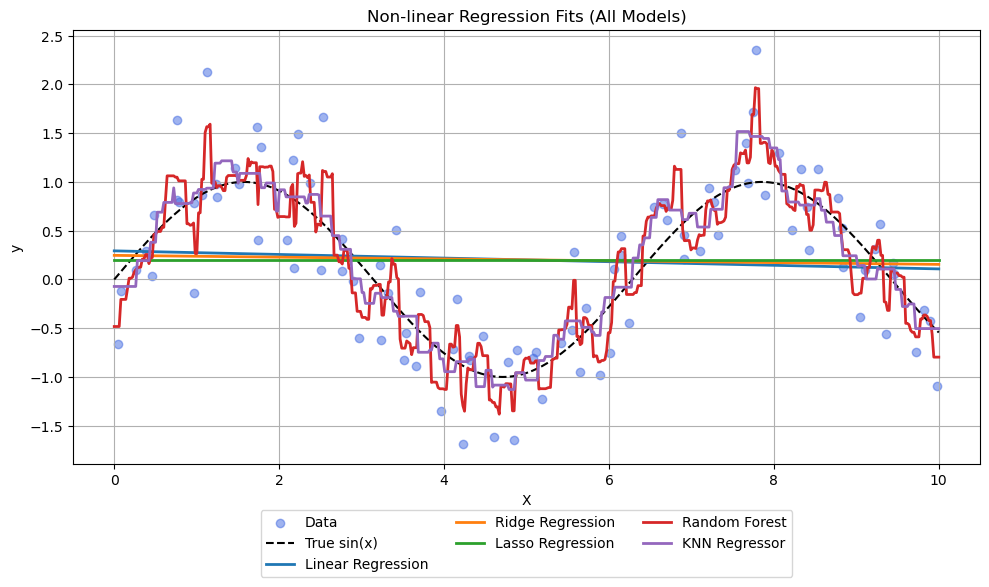

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# 1. Generate non-linear data
np.random.seed(42)
X = np.linspace(0, 10, 100).reshape(-1, 1)
X += np.random.normal(0, .1, size=X.shape)
y = np.sin(X).ravel() + np.random.normal(0, 0.5, X.shape[0])

# 2. Smooth grid for plotting
X_plot = np.linspace(0, 10, 500).reshape(-1, 1)

# 3. Define models
models = {
    'Linear Regression': make_pipeline(StandardScaler(), LinearRegression()),
    'Ridge Regression': make_pipeline(StandardScaler(), Ridge(alpha=100)),
    'Lasso Regression': make_pipeline(StandardScaler(), Lasso(alpha=0.1, max_iter=10000)),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=0),
    'KNN Regressor': KNeighborsRegressor(n_neighbors=5)
}

# 4. Start the main plot
plt.figure(figsize=(10, 6))

# Scatter the data points
plt.scatter(X, y, label='Data', alpha=0.5, color='royalblue')

# Reference true function
plt.plot(X_plot, np.sin(X_plot), color='black', linestyle='--', linewidth=1.5, label='True sin(x)')

# 5. Fit and plot each model
for name, model in models.items():
    model.fit(X, y)
    y_pred = model.predict(X_plot)
    plt.plot(X_plot, y_pred, linewidth=2, label=name)

# 6. Customize plot
plt.title('Non-linear Regression Fits (All Models)')
plt.xlabel('X')
plt.ylabel('y')
plt.grid(True)

# Legend below the plot (horizontal layout)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.09), ncol=3)

plt.tight_layout()
plt.savefig("img/03-model example.pdf")
plt.show()


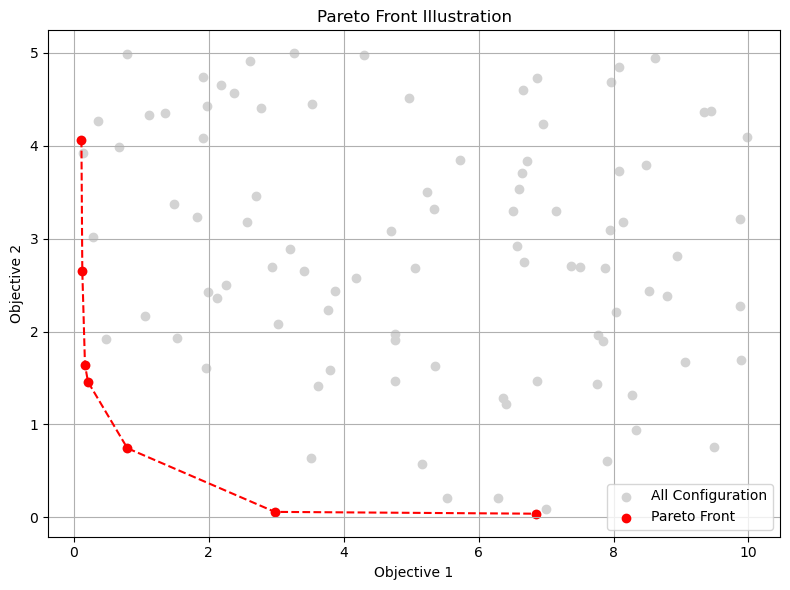

In [58]:
import numpy as np
import matplotlib.pyplot as plt

# 1. Generate random solutions (simulating multi-objective outcomes)

np.random.seed(18)
n_points = 100
objective_1 = np.random.uniform(0, 10, n_points)
objective_2 = np.random.uniform(0, 5, n_points)

points = np.column_stack((objective_1, objective_2))

# 2. Function to find Pareto front (minimize both objectives)
def pareto_front(points):
    pareto_points = []
    for i, point in enumerate(points):
        dominated = False
        for j, other_point in enumerate(points):
            if all(other_point <= point) and any(other_point < point):
                dominated = True
                break
        if not dominated:
            pareto_points.append(point)
    return np.array(pareto_points)

pareto_points = pareto_front(points)

# 3. Plot
plt.figure(figsize=(8, 6))
plt.scatter(points[:, 0], points[:, 1], color='lightgray', label='All Configuration')
plt.scatter(pareto_points[:, 0], pareto_points[:, 1], color='red', label='Pareto Front')
plt.plot(pareto_points[np.argsort(pareto_points[:,0]), 0],
         pareto_points[np.argsort(pareto_points[:,0]), 1],
         color='red', linestyle='--')

plt.title('Pareto Front Illustration')
plt.xlabel('Objective 1')
plt.ylabel('Objective 2')
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.savefig("img/03-pareto_front.pdf")
plt.show()

MLflow server started at http://127.0.0.1:5550
Metadata database: /Users/aflamant/Documents/courses/2024-2025/mémoire/05-results/dummy/001/mlruns.db
Artifacts directory: /Users/aflamant/Documents/courses/2024-2025/mémoire/05-results/dummy/001
Workers: 4
Process group: 42959
MLflow server started at http://127.0.0.1:5551
Metadata database: /Users/aflamant/Documents/courses/2024-2025/mémoire/05-results/dummy/005/mlruns.db
Artifacts directory: /Users/aflamant/Documents/courses/2024-2025/mémoire/05-results/dummy/005
Workers: 4
Process group: 42965


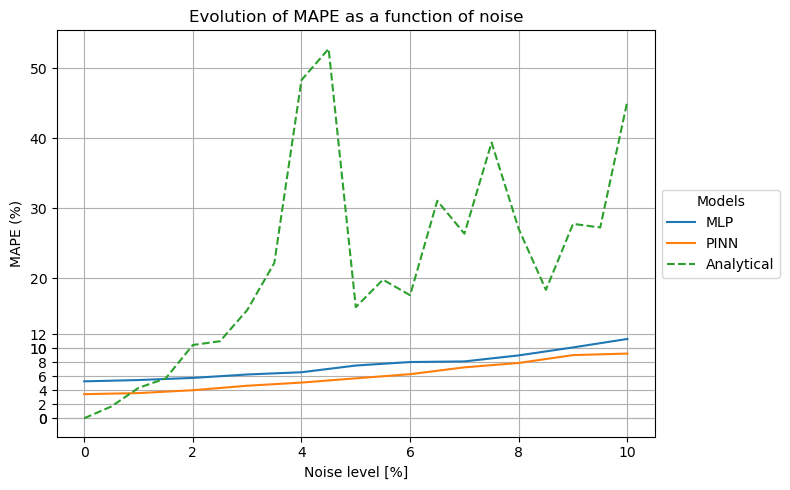

In [1]:
from tools import MLFlowSession
import mlflow
import os
import numpy as np
import matplotlib.pyplot as plt

# Setup a memoire directory variable
memoire_dir = os.environ['memoire']
runs_dir = rf"{memoire_dir}/05-results/dummy"

server_mlp = MLFlowSession(PORT=5550, DIRECTORY=f"{runs_dir}/001")
server_mlp.start()
server_pinn = MLFlowSession(PORT=5551, DIRECTORY=f"{runs_dir}/005")
server_pinn.start()

def get_mape(server):
    mlflow.set_tracking_uri(uri=server.url())
    experiment = mlflow.get_experiment_by_name("noise_sensitivity")

    runs_df = mlflow.search_runs(experiment_ids=[experiment.experiment_id])
    runs_df = runs_df[runs_df['params.train_size']=='4096']

    id = list(runs_df['run_id'])[0]
    client = mlflow.tracking.MlflowClient()
    hist = client.get_metric_history(id, 'mape')
    return np.array([m.value for m in hist])

mape_mlp = get_mape(server_mlp)
mape_pinn = get_mape(server_pinn)
mape_analytical = np.loadtxt("../experiments/dummy_truss/analytical_mean_mape.dat")

fig, ax = plt.subplots(figsize=(8, 5))  # Wider figure for space

# MAPE Plot

plt.plot(100*np.linspace(0, .1, 11), 100*mape_mlp, label='MLP')
plt.plot(100*np.linspace(0, .1, 11), 100*mape_pinn, label='PINN')

# Analytical benchmark
ax.plot(np.linspace(0, .1, 21) * 100, mape_analytical * 100, linestyle='--', label="Analytical")

# Labels and formatting
ax.set_ylabel("MAPE (%)")
ax.set_title("Evolution of MAPE as a function of noise")
ax.set_xlabel("Noise level [%]")
ax.grid(True)

# Move legend outside the plot
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), title="Models")

lim = ax.get_ylim()
ax.set_yticks(np.hstack((ax.get_yticks(), np.arange(0, 13, 2))))
ax.set_ylim(lim)

plt.tight_layout()  # Make room for legend

# Save
fig.savefig(r"img/03_mlp_hybrid_noise.pdf")

plt.show()

server_mlp.terminate()
server_pinn.terminate()

MLflow server started at http://127.0.0.1:5550
Metadata database: /Users/aflamant/Documents/courses/2024-2025/mémoire/05-results/dummy/001/mlruns.db
Artifacts directory: /Users/aflamant/Documents/courses/2024-2025/mémoire/05-results/dummy/001
Workers: 4
Process group: 42973


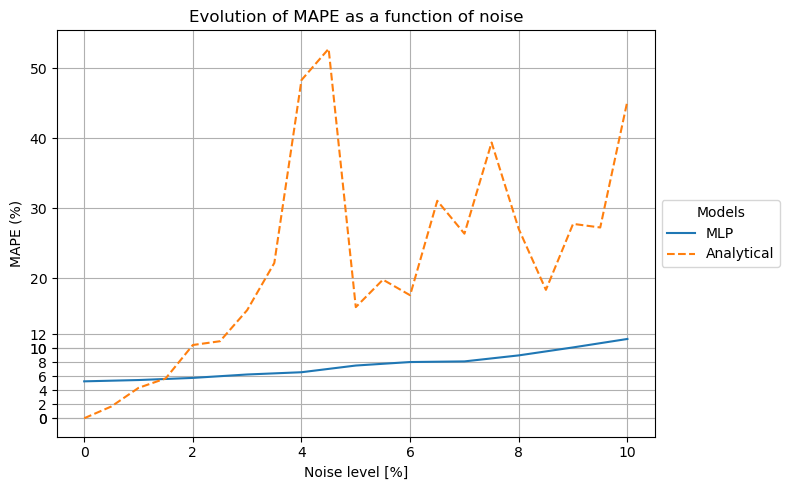

Server not running.


In [2]:
from tools import MLFlowSession
import mlflow
import os
import numpy as np
import matplotlib.pyplot as plt

# Setup a memoire directory variable
memoire_dir = os.environ['memoire']
runs_dir = rf"{memoire_dir}/05-results/dummy"

server_mlp = MLFlowSession(PORT=5550, DIRECTORY=f"{runs_dir}/001")
server_mlp.start()

def get_mape(server):
    mlflow.set_tracking_uri(uri=server.url())
    experiment = mlflow.get_experiment_by_name("noise_sensitivity")

    runs_df = mlflow.search_runs(experiment_ids=[experiment.experiment_id])
    runs_df = runs_df[runs_df['params.train_size']=='4096']

    id = list(runs_df['run_id'])[0]
    client = mlflow.tracking.MlflowClient()
    hist = client.get_metric_history(id, 'mape')
    return np.array([m.value for m in hist])

mape_mlp = get_mape(server_mlp)
mape_analytical = np.loadtxt("../experiments/dummy_truss/analytical_mean_mape.dat")

fig, ax = plt.subplots(figsize=(8, 5))  # Wider figure for space

# MAPE Plot

plt.plot(100*np.linspace(0, .1, 11), 100*mape_mlp, label='MLP')

# Analytical benchmark
ax.plot(np.linspace(0, .1, 21) * 100, mape_analytical * 100, linestyle='--', label="Analytical")

# Labels and formatting
ax.set_ylabel("MAPE (%)")
ax.set_title("Evolution of MAPE as a function of noise")
ax.set_xlabel("Noise level [%]")
ax.grid(True)

# Move legend outside the plot
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), title="Models")

lim = ax.get_ylim()
ax.set_yticks(np.hstack((ax.get_yticks(), np.arange(0, 13, 2))))
ax.set_ylim(lim)

plt.tight_layout()  # Make room for legend

# Save
fig.savefig(r"img/03_mlp_noise.pdf")

plt.show()

server_mlp.terminate()